In [1]:
# Importare le librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import os
import pickle
import json
import datetime
import joblib
import wandb

#### Hyperparams

In [2]:
LR = 0.02
NUM_EPOCHS = 25
SEQ_LENGTH = 6
BATCH_SIZE = 256
HIDDEN_SIZE = 32
NUM_LAYERS = 1
USE_SCALER = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TEST = True
MODEL_PATH = "/home/etosin/Documents/isaaclab_supsi/vacuum/model/grace-sweep-massive-5/comfy-sweep-20_BEST/lstm.jit"

In [3]:
# 1. Importazione del dataset
with open("dataframes_raw.pkl", "rb") as f:
    dfs = pickle.load(f) 

In [4]:
# 2. EDA (Analisi Esplorativa dei Dati)
dfs[0].head()

,Tempo (ms),Voltaggio,Valvola,Pressione,V
937,0.000,5.0,0.0,0.434777,1.0
938,0.005,5.0,0.0,0.434239,1.0
939,0.010,5.0,0.0,0.433702,1.0
940,0.015,5.0,0.0,0.433164,1.0
941,0.020,5.0,0.0,0.432627,1.0


In [5]:
def pad_dfs(dfs):
    new_dfs = []
    for df in dfs:
        tmp = pd.DataFrame(np.array(df.iloc[0].tolist()*10).reshape(10, -1), columns=df.columns)
        df = pd.concat([tmp, df], axis=0, ignore_index=True)
        new_dfs.append(df)
    return new_dfs

In [6]:
df = pad_dfs(dfs)
df = pd.concat(df, ignore_index=True)

In [7]:
print(df.describe())
print(df.info())

         Tempo (ms)     Voltaggio  Valvola     Pressione             V
count  50446.000000  50446.000000  50446.0  50446.000000  50446.000000
mean       4.325022      4.070015      0.0      0.418947      0.845003
std        2.560119      0.830396      0.0      0.091418      0.138399
min        0.000000      3.000000      0.0      0.335840      0.666667
25%        2.120000      3.000000      0.0      0.353834      0.666667
50%        4.295000      4.000000      0.0      0.384840      0.833333
75%        6.470000      5.000000      0.0      0.434282      1.000000
max       10.000000      5.000000      0.0      0.721748      1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50446 entries, 0 to 50445
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tempo (ms)  50446 non-null  float64
 1   Voltaggio   50446 non-null  float64
 2   Valvola     50446 non-null  float64
 3   Pressione   50446 non-null  float64
 4   V 

In [8]:
# Creazione di sequenze di dati per LSTM
def create_sequences(features, targets, seq_length):
    sequences = []
    for i in range(len(features) - seq_length):
        seq = features[i:i+seq_length]
        label = targets[i+seq_length]
        sequences.append((seq.tolist(), label.tolist()))
    return sequences

In [9]:
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(df["Tempo (ms)"].values, fill=True)
plt.title('Time [ms]')

plt.subplot(1, 2, 2)
sns.kdeplot(df["V"].values, fill=True)
plt.title('Voltage [V]')

plt.close()

In [10]:
# 1 atm = 1.01325 bar (ours) FORZA GRAFICO
# bar = 1.01325
# vacuum_area = 0.000625 * 9
# pression_from_nn = 0
# computed_effort = (bar - pression_from_nn) * vacuum_area

In [11]:
# 3. Preparazione dei dati
X = df[['Tempo (ms)', 'V']].values
y = df['Pressione'].values


# # Normalizzazione dei dati
if USE_SCALER:
    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    

seq = create_sequences(X, y, SEQ_LENGTH)
X, y = zip(*seq)

# Suddivisione dei dati in train, validation e test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Conversione in tensori
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32, device=device).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device).unsqueeze(1)

# Creazione dei DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

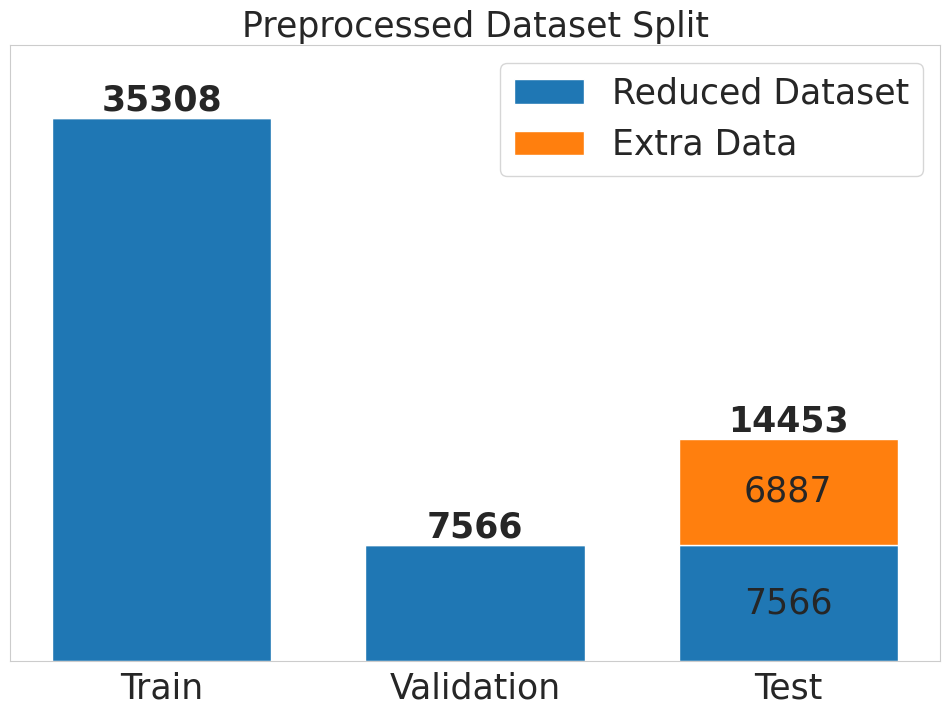

In [12]:
# codice barplot split dataset

total_unseens = 6887

fig, ax = plt.subplots(figsize=(12, 8))
labels = ['Train', 'Validation', 'Test']
sizes = [len(X_train_tensor), len(X_val_tensor), len(X_test_tensor)]
sizes2 = [0, 0, total_unseens]

x = np.arange(len(labels))
x = x / 2
width = 0.35  # Larghezza delle barre

bars1 = ax.bar(x, sizes, width, label='Reduced Dataset')
bars2 = ax.bar(x, sizes2, width, bottom=sizes, label='Extra Data')

for idx, bar in enumerate(bars1):
    height = bar.get_height()
    if idx == 2:
        ax.text(bar.get_x() + bar.get_width() / 2.0, height/2, str(height), ha='center', va='center', fontsize=25)
    else:
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, str(height), ha='center', va='bottom', fontsize=25, fontweight='bold')

for idx, bar in enumerate(bars2):
    height = bar.get_height() + sizes[idx]
    if height != sizes[idx]:
        ax.text(bar.get_x() + bar.get_width() / 2.0, height-bar.get_height()/2, str(bar.get_height()), ha='center', va='center', fontsize=25)
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, str(height), ha='center', va='bottom', fontsize=25, fontweight='bold')


plt.xticks(ticks=x, labels=labels, fontsize=25)  # Imposta i nomi sull'asse x
plt.title("Preprocessed Dataset Split", fontsize=25)
plt.legend(fontsize=25)
ax.grid(False)
plt.ylim(0, 40000)# Rimuovere l'asse Y
ax.yaxis.set_visible(False)
plt.savefig("dataset_split_no2v.svg", format='svg')
plt.show()

In [13]:
# 4. Creazione dei modelli
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=50, output_size=1, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [15]:
# 5. Addestramento dei modelli
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')
    
    return train_losses, val_losses

# Inizializzazione dei modelli
# mlp_model = MLP()
lstm_model = LSTM(hidden_layer_size=32, num_layers=NUM_LAYERS).to(device)

In [17]:
# Addestramento del LSTM
train_losses_lstm, val_losses_lstm = train_model(lstm_model, train_loader, val_loader, num_epochs=NUM_EPOCHS, learning_rate=0.001)

Epoch 1, Train Loss: 0.005836984006579598, Val Loss: 0.0036800128279080935
Epoch 2, Train Loss: 0.0035372234170094803, Val Loss: 0.003250288724003336
Epoch 3, Train Loss: 0.003056109744568897, Val Loss: 0.002746201895927924
Epoch 4, Train Loss: 0.0028093387010048373, Val Loss: 0.0027158775630619237
Epoch 5, Train Loss: 0.002779965868799279, Val Loss: 0.002656292781343817
Epoch 6, Train Loss: 0.0027732617288785295, Val Loss: 0.002660539627756986
Epoch 7, Train Loss: 0.0027471628751115622, Val Loss: 0.002772294046536072
Epoch 8, Train Loss: 0.002756393857808966, Val Loss: 0.0026589820519058263
Epoch 9, Train Loss: 0.0027434795270707673, Val Loss: 0.002685202547950269
Epoch 10, Train Loss: 0.0027476270001964135, Val Loss: 0.002789107985639324
Epoch 11, Train Loss: 0.002750408940050545, Val Loss: 0.0026783008606837207
Epoch 12, Train Loss: 0.0027362953959828187, Val Loss: 0.0028023911678853133
Epoch 13, Train Loss: 0.002739905928968295, Val Loss: 0.0026551546842814716
Epoch 14, Train Loss:

In [16]:
# 6. Valutazione dei modelli
def evaluate_model(model, data_loader, do_estimate=True, preds=None, trues=None):
    if do_estimate:
        model.eval()
        predictions, actuals = [], []
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                y_pred = model(X_batch)
                predictions.append(y_pred.tolist())
                actuals.append(y_batch.tolist())
        
        predictions = np.concatenate(predictions, axis=0)
        actuals = np.concatenate(actuals, axis=0)
    else:
        predictions, actuals = preds, trues
        
    
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    
    return mae, mse, mape, predictions, actuals

# Valutazione sul validation set
# mae_mlp_val, mse_mlp_val, mape_mlp_val, _, _ = evaluate_model(mlp_model, val_loader)
mae_lstm_val, mse_lstm_val, mape_lstm_val, _, _ = evaluate_model(lstm_model, val_loader)
# 
# # Valutazione sul test set
# mae_mlp_test, mse_mlp_test, mape_mlp_test, predictions_mlp, actuals_mlp = evaluate_model(mlp_model, test_loader)
mae_lstm_test, mse_lstm_test, mape_lstm_test, predictions_lstm, actuals_lstm = evaluate_model(lstm_model, test_loader)

In [17]:
# 7. Confronto delle prestazioni dei modelli
# print(f'MLP Validation - MAE: {mae_mlp_val}, MSE: {mse_mlp_val}, MAPE: {mape_mlp_val}')
print(f'LSTM Validation - MAE: {mae_lstm_val}, MSE: {mse_lstm_val}, MAPE: {mape_lstm_val}')

# print(f'MLP Test - MAE: {mae_mlp_test}, MSE: {mse_mlp_test}, MAPE: {mape_mlp_test}')
print(f'LSTM Test - MAE: {mae_lstm_test}, MSE: {mse_lstm_test}, MAPE: {mape_lstm_test}')

# Plot delle perdite durante l'addestramento
# plt.plot(train_losses_mlp, label='Train Loss MLP')
# plt.plot(val_losses_mlp, label='Validation Loss MLP')
plt.plot(train_losses_lstm, label='Train Loss LSTM')
plt.plot(val_losses_lstm, label='Validation Loss LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot delle predizioni vs. valori reali per il set di test
show_first = 500

plt.figure(figsize=(10, 5))
plt.plot(actuals_lstm[:show_first])
plt.plot(predictions_lstm[:show_first], '--')
plt.xlabel('Valori Reali')
plt.ylabel('Predizioni')
plt.title('LSTM Predizioni vs Valori Reali')
plt.show()


LSTM Validation - MAE: 0.41782685899562955, MSE: 0.18708669790684235, MAPE: 0.990501502707074
LSTM Test - MAE: 0.4191231885663978, MSE: 0.1883346772020146, MAPE: 0.9920435011363151


NameError: name 'train_losses_lstm' is not defined

In [18]:
from scipy.signal import butter,filtfilt # Filter requirements.
T = 0.005         # Sample Period
fs = 1/T       # sample rate, Hz
cutoff = 1    # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hznyq = 0.5 * fs  # Nyquist Frequencyorder = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples
nyq = 0.5 * fs  # Nyquist Frequencyorder = 2       # sin wave can be approx represented as quadratic

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [19]:
files_dict = {}
def create_dataframe_from_files(directory):
    data_list = []
    for root, dirs, files in os.walk(directory):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            # Esempio: lettura di dati da file CSV
            if file_name.endswith('.csv'):
                df = pd.read_csv(file_path)
                print(file_name, "---", len(df))
                files_dict[file_name] = len(df)
                df["Tempo (ms)"] = df["Tempo (ms)"].astype(float)
                df["Forza (N)"] = df["Forza (N)"].astype(float)
                df["Valvola"] = df["Stato X11"].astype(float)
                df["Pressione"] = df["Pressione"].astype(float)
                df["Voltaggio"] = df["Voltaggio"].astype(float)
                df = df.reindex(columns=["Tempo (ms)","Voltaggio","Valvola","Pressione"])
                # df = pd.concat([df_header, df], ignore_index=True)
                
                pressure = df["Pressione"].tolist()[500:]
                filtered = butter_lowpass_filter(pressure, cutoff, fs, order=2)
                gradient = np.gradient(filtered, 0.005)
                
                start = 500+gradient.tolist().index(gradient.max())-50
                end = 500+gradient.tolist().index(gradient[1000+start:].max())-100
                
                
                # plt.plot(pressure, label="pressure")
                # plt.plot(filtered, label="filtered")
                # plt.plot(gradient, label="gradient")
                # plt.axvline(start, color='r')
                # plt.axvline(end, color='r')
                # plt.legend()
                # plt.title(file_name)
                # plt.show()
                
                data_cut = df.iloc[start:end]
                data_cut["Tempo (ms)"] = np.arange(0,end-start)*0.005
                data_list.append(data_cut)

    if data_list:
        # return pd.concat(data_list, ignore_index=True)
        return data_list
    else:
        return None

In [20]:
def evaluate_model_unseen(lstm_model, df_unseen):
    df_unseen["V"] = (df_unseen["Voltaggio"]+1)/6

    mask_valvola_on = df_unseen["Valvola"]<=0.5
    mask_valvola_off = df_unseen["Valvola"]>0.5
    
    df_unseen.loc[mask_valvola_on, "V"] = 0
    df_unseen.loc[mask_valvola_on, "Valvola"] = 1
    df_unseen.loc[mask_valvola_off, "Valvola"] = 0
    
    X = df_unseen[['Tempo (ms)', 'V']].values
    y = df_unseen['Pressione'].values
    
    if USE_SCALER:
        X = scaler.transform(X)
    
    seq = create_sequences(X, y, SEQ_LENGTH)
    X, y_true = zip(*seq)
    
    
    lstm_model.eval()
    with torch.no_grad():
        pred_lstm = lstm_model(torch.tensor(X, device=device).float()).flatten().tolist()
    
    return y_true, pred_lstm

In [21]:
def compute_force(press):
    bar = 1.01325
    vacuum_area = 0.000625 * 9
    deltap = bar - press
    deltap_pascal = deltap * 10**5
    forza = deltap_pascal * vacuum_area
    return forza

In [22]:
if TEST:
    lstm_model = torch.jit.load(MODEL_PATH)

test39_updated_5milli.csv --- 3984
test34_updated_5milli.csv --- 4141
test21_updated_5milli.csv --- 4068
test28_updated_5milli.csv --- 3990
LSTM Test - MAE: 0.021929, MSE: 0.000867, MAPE: 0.059664


/tmp/ipykernel_1438540/1980670748.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cut["Tempo (ms)"] = np.arange(0,end-start)*0.005
/tmp/ipykernel_1438540/1980670748.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cut["Tempo (ms)"] = np.arange(0,end-start)*0.005
/tmp/ipykernel_1438540/1980670748.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

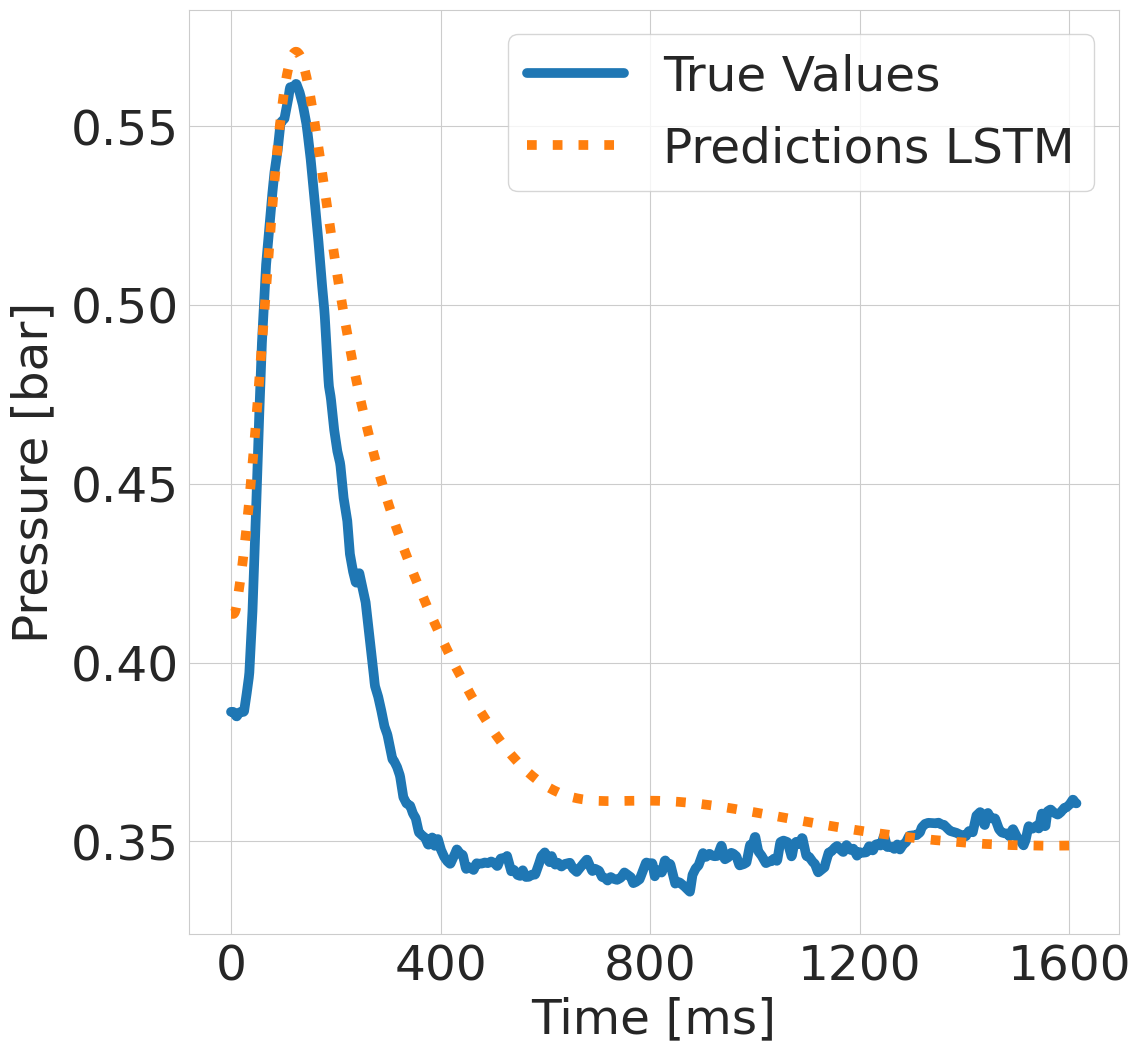

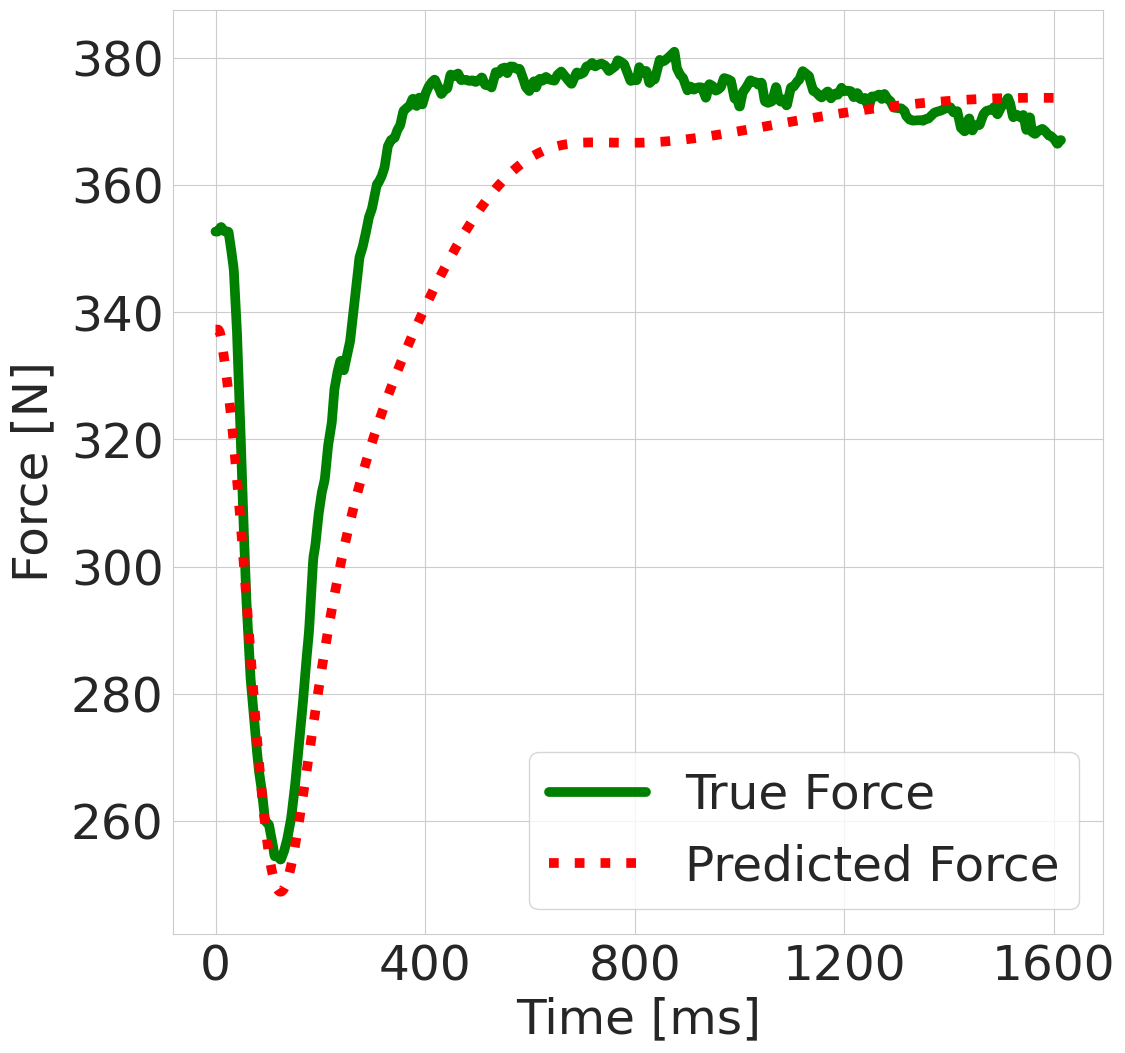

LSTM Test - MAE: 0.017048, MSE: 0.000724, MAPE: 0.038423


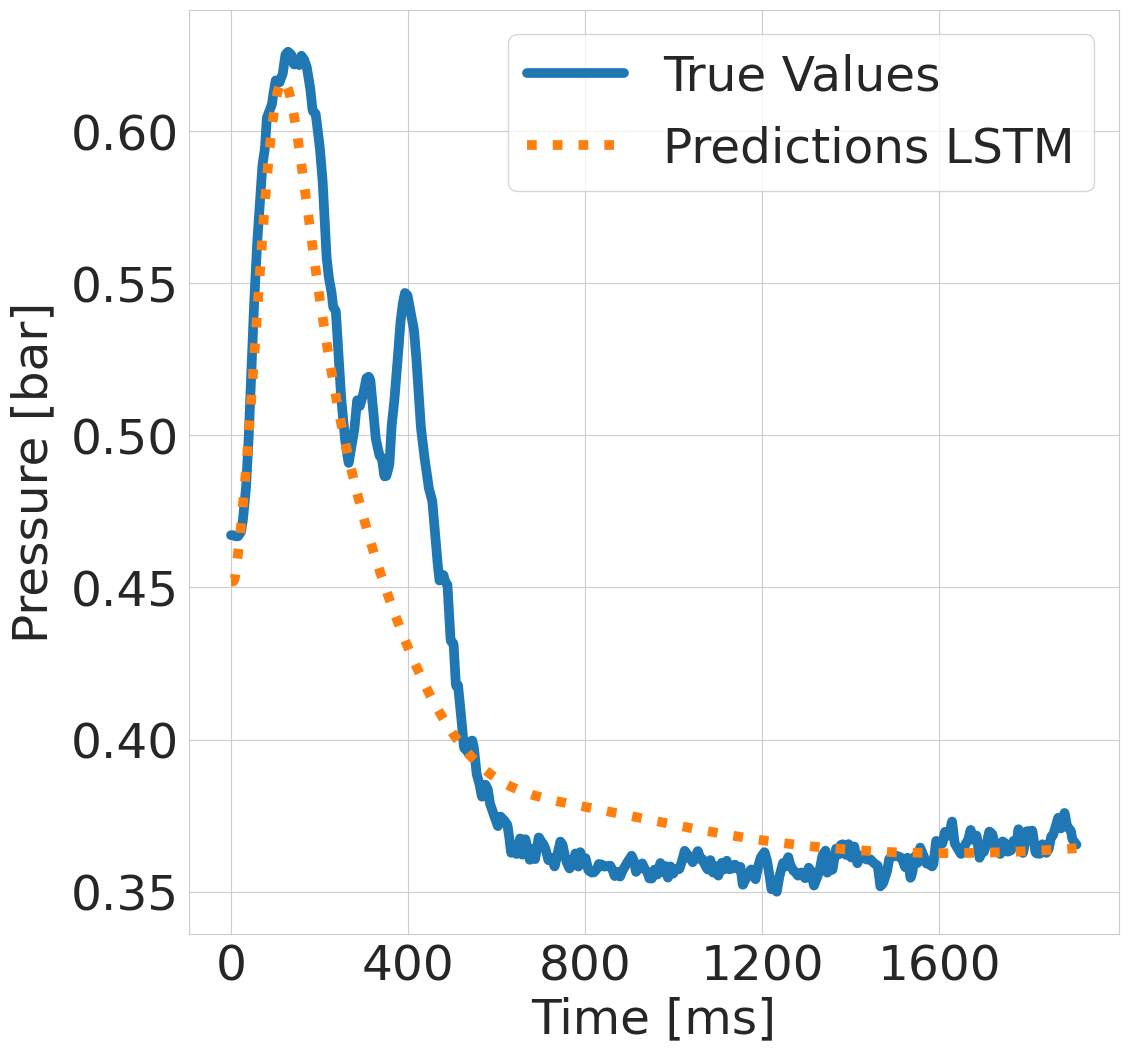

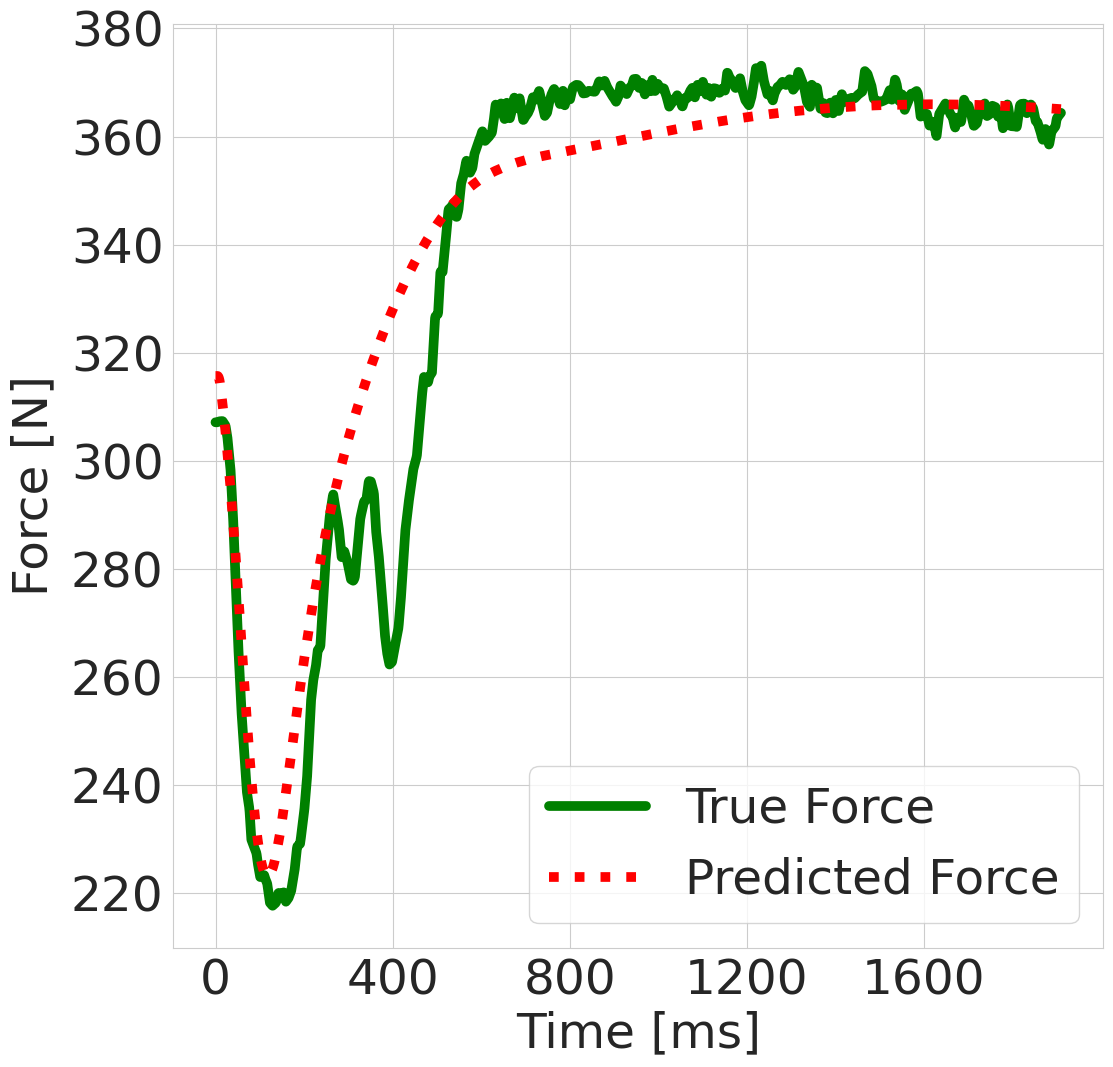

LSTM Test - MAE: 0.023530, MSE: 0.000834, MAPE: 0.049221


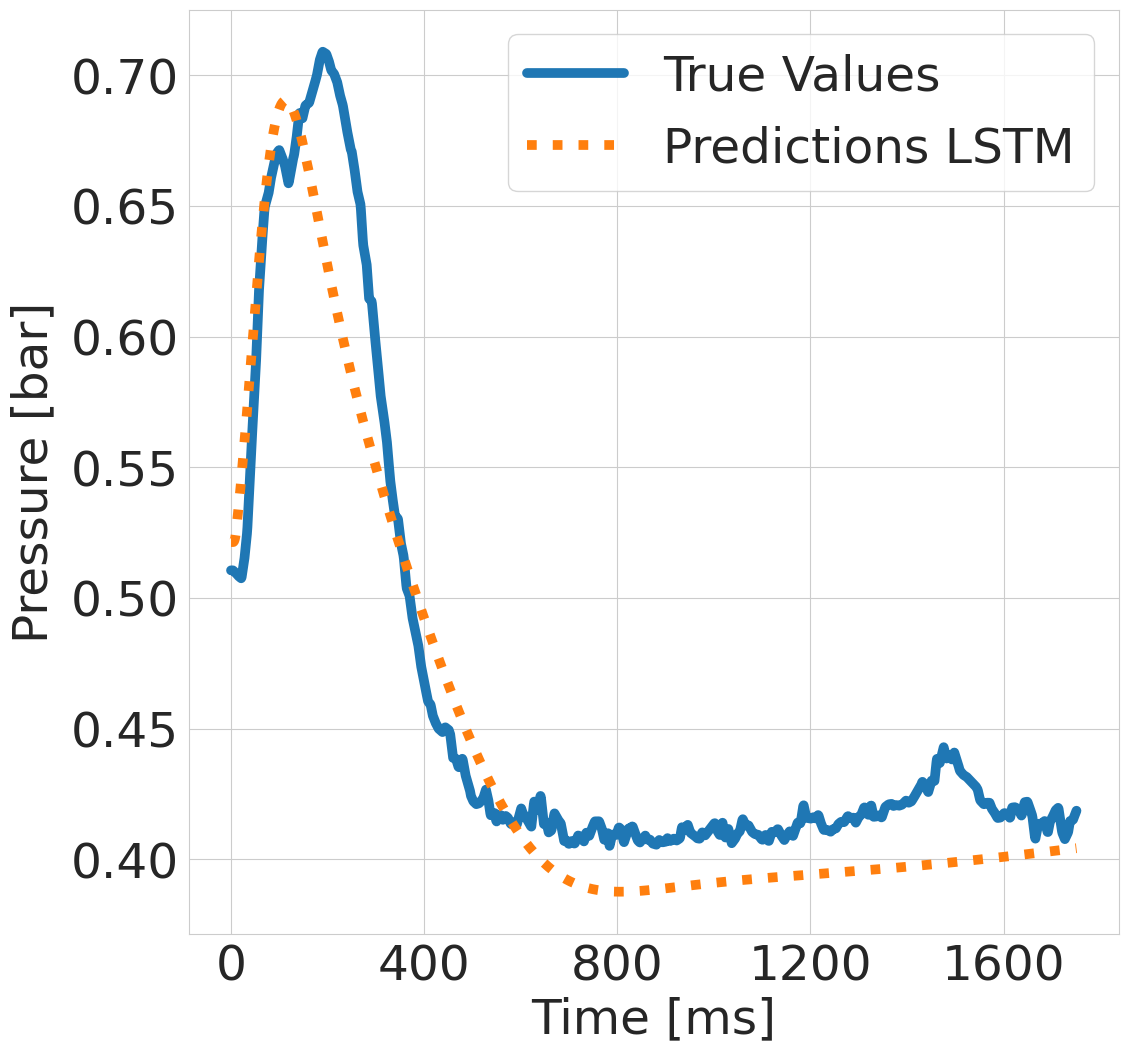

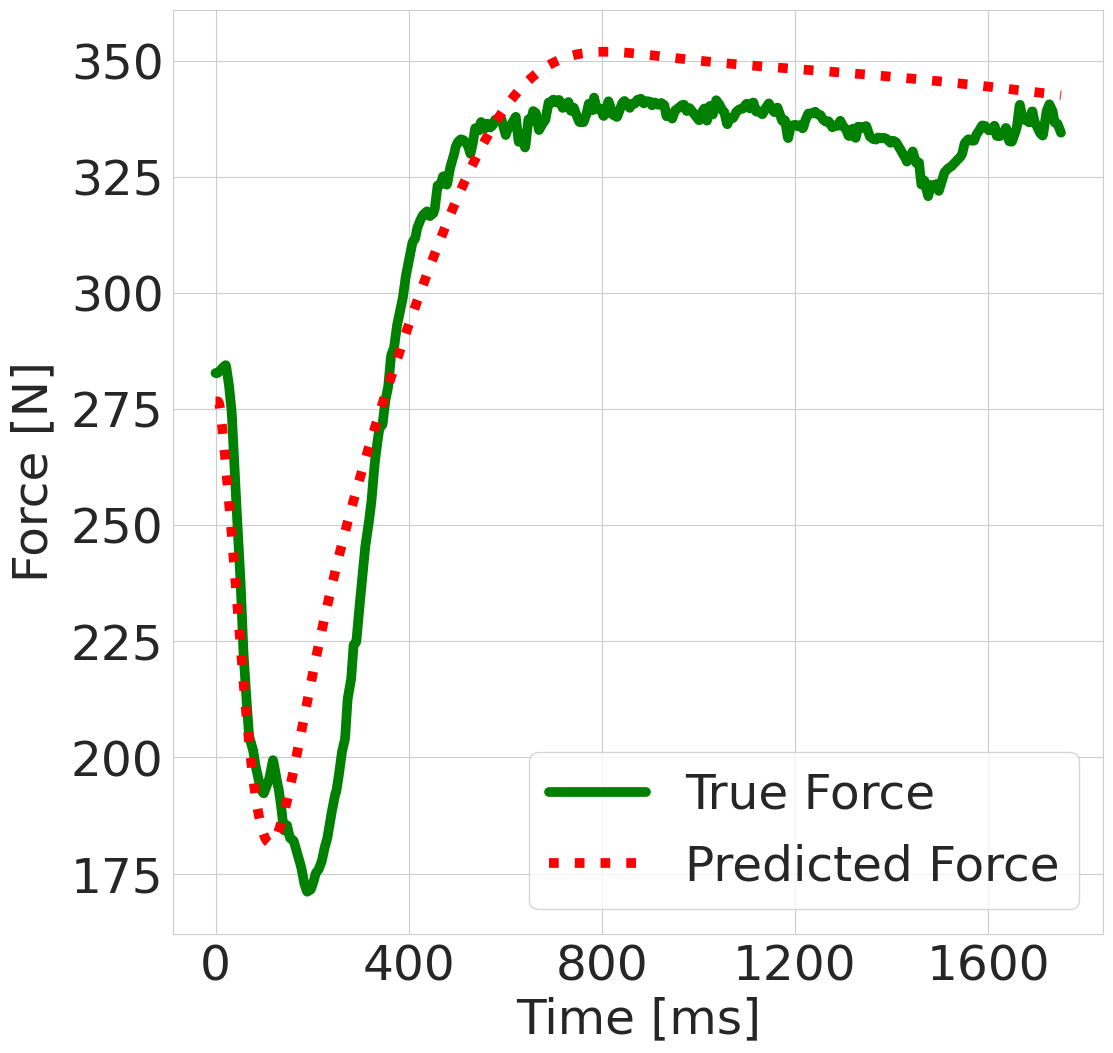

LSTM Test - MAE: 0.024307, MSE: 0.000876, MAPE: 0.062451


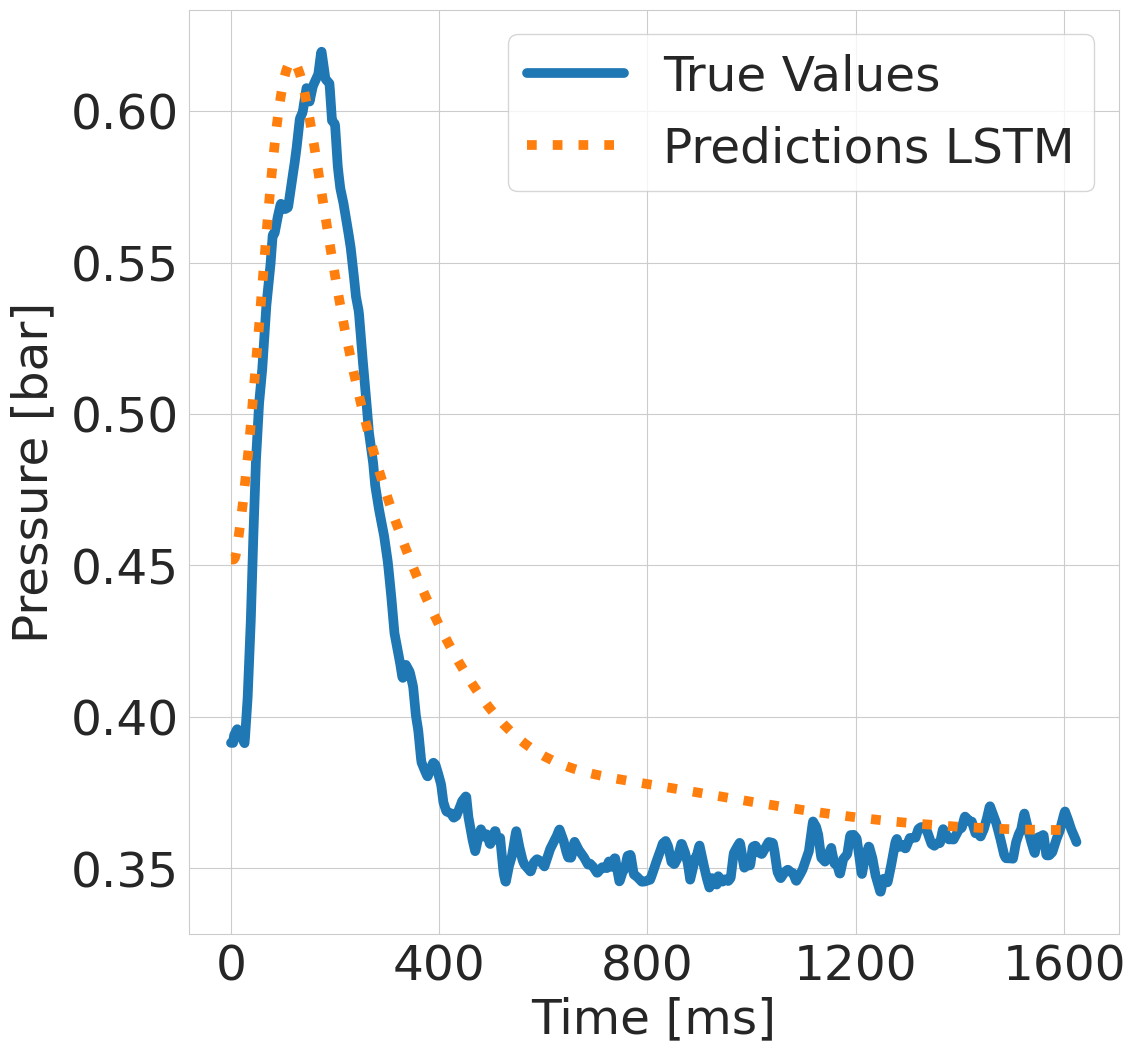

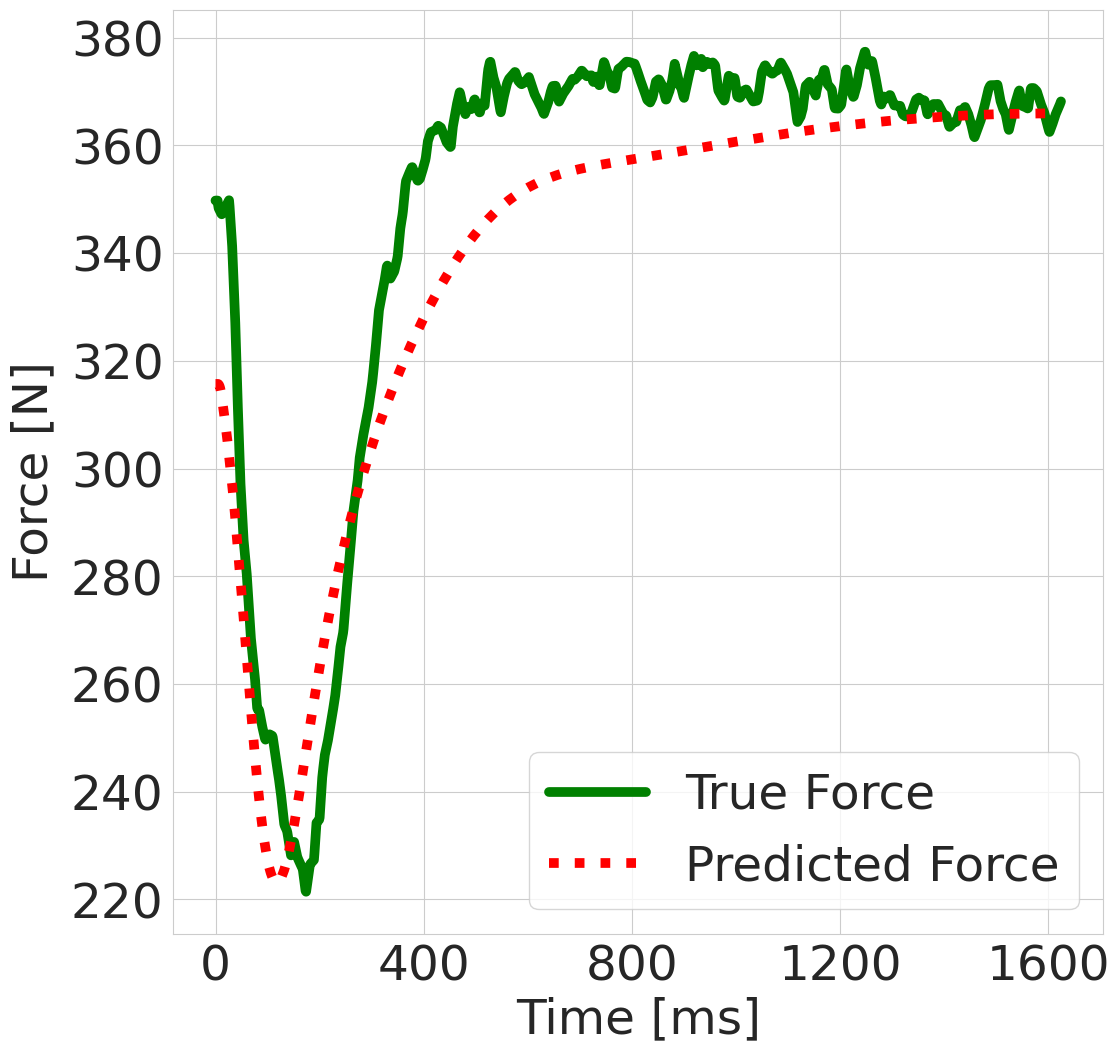

In [30]:
df_unseens = create_dataframe_from_files("/home/etosin/Documents/isaaclab_supsi/vacuum/test_DOE_5milli")

hyperparams = {
    "seq_length": SEQ_LENGTH,
    "batch_size": BATCH_SIZE,
    "hidden_size": HIDDEN_SIZE,
    "epochs": NUM_EPOCHS,
    "num_layers": NUM_LAYERS,
    "lr":LR,
    "MAE_TEST": str(mae_lstm_test),
    "MSE_TEST": str(mse_lstm_test),
    "MAPE_TEST": str(mape_lstm_test)
}
percorso_base = "/home/etosin/Documents/isaaclab_supsi/vacuum/model/"
testnr = 10

# timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp = f"loocv {testnr}"
percorso_cartella = os.path.join(percorso_base, timestamp)
os.makedirs(percorso_cartella, exist_ok=True)

percorso_json = os.path.join(percorso_cartella, "hyperparams.json")
with open(percorso_json, mode='w', encoding='utf-8') as file_json:
    json.dump(hyperparams, file_json, indent=4, ensure_ascii=False)
    
jit_model = torch.jit.script(lstm_model)
torch.jit.save(jit_model, os.path.join(percorso_cartella, "lstm.jit"))

if USE_SCALER:
    scaler_filename = "RobustScaler.save"
    joblib.dump(scaler, os.path.join(percorso_cartella, scaler_filename))

df_unseens = pad_dfs(df_unseens)
total_unseens = 0
for idx, data in enumerate(df_unseens):
    y_true, pred_lstm = evaluate_model_unseen(lstm_model, data)
    total_unseens += len(data)
    
    mae, mse, mape, _, _ = evaluate_model(lstm_model, None, do_estimate=False, preds=pred_lstm, trues=y_true)
    print(f'LSTM Test - MAE: {mae:4f}, MSE: {mse:4f}, MAPE: {mape:4f}')
    with open(os.path.join(percorso_cartella, "test_metrics.txt"), "a") as f:
        f.write(f"{list(files_dict.keys())[idx]} - MAE: {mae:4f}, MSE: {mse:4f}, MAPE: {mape:4f} \n\n")
    fontsize = 35
    linewidth = 7
    
    # Visualizzazione dei risultati
    plt.figure(figsize=(12,12))
    plt.plot(y_true, label='True Values', linewidth=linewidth)
    plt.plot(pred_lstm, label='Predictions LSTM', linestyle='dotted', linewidth=linewidth)
    plt.xlabel('Time [ms]', fontsize=fontsize)
    plt.ylabel('Pressure [bar]', fontsize=fontsize, labelpad=10)
    # angle = 0
    # angle_dir = 0
    # plt.suptitle(r"VOLTAGE: 2 - $\alpha$: {angle} - $\beta$: {angle_dir} - TEST{testnr}")
    # plt.title(f"MAE: {mae:.6f}, MSE: {mse:.6f}, MAPE: {mape:.6f}")
    ticks = [0, 400, 800, 1200, 1600]
    plt.xticks(ticks=ticks, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.savefig(os.path.join(percorso_cartella, f"test_{idx}.svg"), format='svg')
    plt.show()
    
    plt.figure(figsize=(12,12))
    force_true = [compute_force(y) for y in y_true]
    force_lstm = [compute_force(p) for p in pred_lstm]
    plt.plot(force_true, label='True Force', linewidth=linewidth, color="green")
    plt.plot(force_lstm, label='Predicted Force', linestyle='dotted', linewidth=linewidth, color="red")
    plt.xlabel('Time [ms]', fontsize=fontsize)
    plt.ylabel('Force [N]', fontsize=fontsize, labelpad=10)
    ticks = [0, 400, 800, 1200, 1600]
    plt.xticks(ticks=ticks, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.savefig(os.path.join(percorso_cartella, f"test_{idx}_force.svg"), format='svg')
    plt.show()

In [24]:
# fig, ax = plt.subplots(figsize=(12, 8))
# labels = ['Train', 'Validation', 'Test']
# sizes = [len(X_train_tensor), len(X_val_tensor), len(X_test_tensor)]
# sizes2 = [0, 0, total_unseens]
# 
# x = np.arange(len(labels))
# x = x / 2
# width = 0.35  # Larghezza delle barre
# 
# bars1 = ax.bar(x, sizes, width, label='Reduced Dataset')
# bars2 = ax.bar(x, sizes2, width, bottom=sizes, label='Extra Data')
# 
# for idx, bar in enumerate(bars1):
#     height = bar.get_height()
#     if idx == 2:
#         ax.text(bar.get_x() + bar.get_width() / 2.0, height/2, str(height), ha='center', va='center', fontsize='xx-large')
#     else:
#         ax.text(bar.get_x() + bar.get_width() / 2.0, height, str(height), ha='center', va='bottom', fontsize='xx-large', fontweight='bold')
#     
# for idx, bar in enumerate(bars2):
#     height = bar.get_height() + sizes[idx]
#     if height != sizes[idx]:
#         ax.text(bar.get_x() + bar.get_width() / 2.0, height-bar.get_height()/2, str(bar.get_height()), ha='center', va='center', fontsize='xx-large')
#         ax.text(bar.get_x() + bar.get_width() / 2.0, height, str(height), ha='center', va='bottom', fontsize='xx-large', fontweight='bold')
#         
# 
# plt.xticks(ticks=x, labels=labels, fontsize=20)  # Imposta i nomi sull'asse x
# plt.title("Preprocessed Dataset Split", fontsize=20)
# plt.legend(fontsize=20)
# ax.grid(False)
# plt.ylim(0, 52500)# Rimuovere l'asse Y
# ax.yaxis.set_visible(False)
# plt.savefig(os.path.join(percorso_cartella, f"dataset_split.svg"), format='svg')
# plt.show()

##### Comparison Massive4-5

In [25]:
# model_new = torch.jit.load("/home/etosin/Documents/isaaclab_supsi/vacuum/model/grace-sweep-massive-5/comfy-sweep-20_BEST/lstm.jit")
# 
# input = torch.rand((100, 6, 2), device=device)

In [26]:
# %%timeit
# 
# out = model_new(input)

In [27]:
# model_old = torch.jit.load("/home/etosin/Documents/isaaclab_supsi/vacuum/model/grace-sweep-massive-4/charmed-sweep-23_BEST/lstm.jit")
# 
# input = torch.rand((100, 30, 2), device=device)

In [28]:
# %%timeit
# 
# out = model_old(input)